# RNN Classifier con PyTorch Lightning
## Trabajo Computacional 2

Este notebook implementa un clasificador RNN para predecir el origen de nombres utilizando PyTorch Lightning.

### Objetivos
- Implementar un modelo RNN, LSTM y GRU para la tarea de clasificación usando PyTorch Lightning
- Modularizar el código en componentes reutilizables:
  - `model.py`: Definición del modelo RNN
  - `datamodule.py`: Manejo de datos y preprocessing
  - `train.py`: Loop de entrenamiento y evaluación

## Instalación y configuración

Primero instalamos las dependencias necesarias e importamos las bibliotecas.

In [1]:
# Instalar PyTorch Lightning si no está instalado
# !pip install lightning

In [ ]:
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import time

# Importar módulos personalizados
from utils.model import RNNClassifier
from utils.datamodule import RNNDataset, RNNDataModule, n_letters
from utils.eval import evaluate_model, plot_confusion_matrix, predict_name_origin

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar
torch.manual_seed(47)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.3.0+cu121
PyTorch Lightning version: 2.5.3
Device: CUDA


## Preparación de datos

Descargamos y preparamos los datos de nombres si no están disponibles.

In [3]:
# Descargar datos si no existen
if not os.path.exists('./data'):
    print("Descargando datos...")
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data.zip
    !rm data.zip
    print("Datos descargados exitosamente!")
else:
    print("Los datos ya están disponibles.")

Los datos ya están disponibles.


### Distribución de datos y balanceo

Al cargar e inspeccionar los datos, estos se encontraban muy desbalanceados. Para poder definir las épocas adecuadamente se hizo un sobremuestreo de las clases con menos datos y con esto tener una distribución más equitativa de los datos

In [4]:
# Cargamos el dataset
dataset = RNNDataset(data_path="./data/names/", balanced=True, verbose=True)

Cargando datos desde ./data/names/...


Polish: 139 ejemplos
Greek: 203 ejemplos
Chinese: 268 ejemplos
Scottish: 100 ejemplos
Italian: 709 ejemplos
German: 724 ejemplos
Dutch: 297 ejemplos
Arabic: 2000 ejemplos
Portuguese: 74 ejemplos
English: 3668 ejemplos
Russian: 9408 ejemplos
French: 277 ejemplos
Czech: 519 ejemplos
Japanese: 991 ejemplos
Spanish: 298 ejemplos
Korean: 94 ejemplos
Vietnamese: 73 ejemplos
Irish: 232 ejemplos

Balanceando dataset...
Polish - nuevo tamaño: 9313
Greek - nuevo tamaño: 9338
Chinese - nuevo tamaño: 9380
Scottish - nuevo tamaño: 9400
Italian - nuevo tamaño: 9217
German - nuevo tamaño: 8688
Dutch - nuevo tamaño: 9207
Arabic - nuevo tamaño: 8000
Portuguese - nuevo tamaño: 9398
English - nuevo tamaño: 7336
French - nuevo tamaño: 9141
Czech - nuevo tamaño: 9342
Japanese - nuevo tamaño: 8919
Spanish - nuevo tamaño: 9238
Korean - nuevo tamaño: 9400
Vietnamese - nuevo tamaño: 9344
Irish - nuevo tamaño: 9280


In [5]:
categories = dataset.categories

print(f"Número total de categorías: {len(categories)}")
print(f"Categorías disponibles: {categories}")

print(f"\nEjemplos de entrenamiento:")
for i in range(5):
    category, line, category_tensor, line_tensor = dataset.get_random_sample()
    print(f"category = {category} / line = {line}")


Número total de categorías: 18
Categorías disponibles: ['Polish', 'Greek', 'Chinese', 'Scottish', 'Italian', 'German', 'Dutch', 'Arabic', 'Portuguese', 'English', 'Russian', 'French', 'Czech', 'Japanese', 'Spanish', 'Korean', 'Vietnamese', 'Irish']

Ejemplos de entrenamiento:
category = Vietnamese / line = Lieu
category = Italian / line = Caro
category = Portuguese / line = Alves
category = Irish / line = Finn
category = Japanese / line = Futabatei


## Entrenamiento del modelo

Ahora entrenamos el modelo RNN usando PyTorch Lightning.

In [6]:
# Configuración del entrenamiento
CONFIG = {
    'hidden_size': 128,
    'learning_rate': 0.005,
    'n_epochs': 1,
    'batch_size': 64,
    'num_workers': 40,
}

print("Configuración del entrenamiento:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuración del entrenamiento:
  hidden_size: 128
  learning_rate: 0.005
  n_epochs: 1
  batch_size: 64
  num_workers: 40


In [7]:
# Crear la instancia del modelo RNN
print("Creando modelo RNN...")

data_module = RNNDataModule(data_path="./data/names/", batch_size=CONFIG['batch_size'], num_workers=40)
categories = dataset.get_categories()

# Crear el modelo con la configuración especificada
model = RNNClassifier(
    input_size=n_letters,
    hidden_size=CONFIG['hidden_size'],
    output_size=len(categories),
    learning_rate=CONFIG['learning_rate']
)

print(f"Modelo creado exitosamente!")
print(f"Arquitectura del modelo:")
print(f"  - Input size: {n_letters} (caracteres)")
print(f"  - Hidden size: {CONFIG['hidden_size']}")
print(f"  - Output size: {len(categories)} (categorías)")
print(f"  - Learning rate: {CONFIG['learning_rate']}")

Creando modelo RNN...
Modelo creado exitosamente!
Arquitectura del modelo:
  - Input size: 57 (caracteres)
  - Hidden size: 128
  - Output size: 18 (categorías)
  - Learning rate: 0.005


In [8]:
# Inicialización del modulo lightning

callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="valid_acc") # guardamos el mejor modelo monitoreado en la acc de validación.

callback_tqdm = RichProgressBar(leave=True)

logger = CSVLogger(save_dir="logs/", name="rnn-classifier")

In [ ]:
# Inicia entrenamiento

trainer = pl.Trainer(max_epochs=CONFIG['n_epochs'],
                    callbacks=[callback_check, callback_tqdm],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    deterministic=False,
                    log_every_n_steps=10)

start_time = time.time()
trainer.fit(model = model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

print("¡Entrenamiento completado!")

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ base_model │ RNN                │ 23.9 K │ train │
│ 1 │ out        │ Linear             │  2.3 K │ train │
│ 2 │ softmax    │ LogSoftmax         │      0 │ train │
│ 3 │ criterion  │ NLLLoss            │      0 │ train │
│ 4 │ train_acc  │ MulticlassAccuracy │      0 │ train │
│ 5 │ valid_acc  │ MulticlassAccuracy │      0 │ train │
│ 6 │ test_acc   │ MulticlassAccuracy │      0 │ train │
└───┴────────────┴────────────────────┴────────┴───────┘

Trainable params: 26.3 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.3 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0

Output()

## Evaluación del modelo

Evaluamos el modelo entrenado y visualizamos los resultados.

Evaluando el modelo...
Precisión: 0.7220
Número de categorías: 18


/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/train.py:169: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + categories, rotation=90)
/home/eaguayo/workspace/DeepLearning/rnn-classifier/utils/train.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + categories)


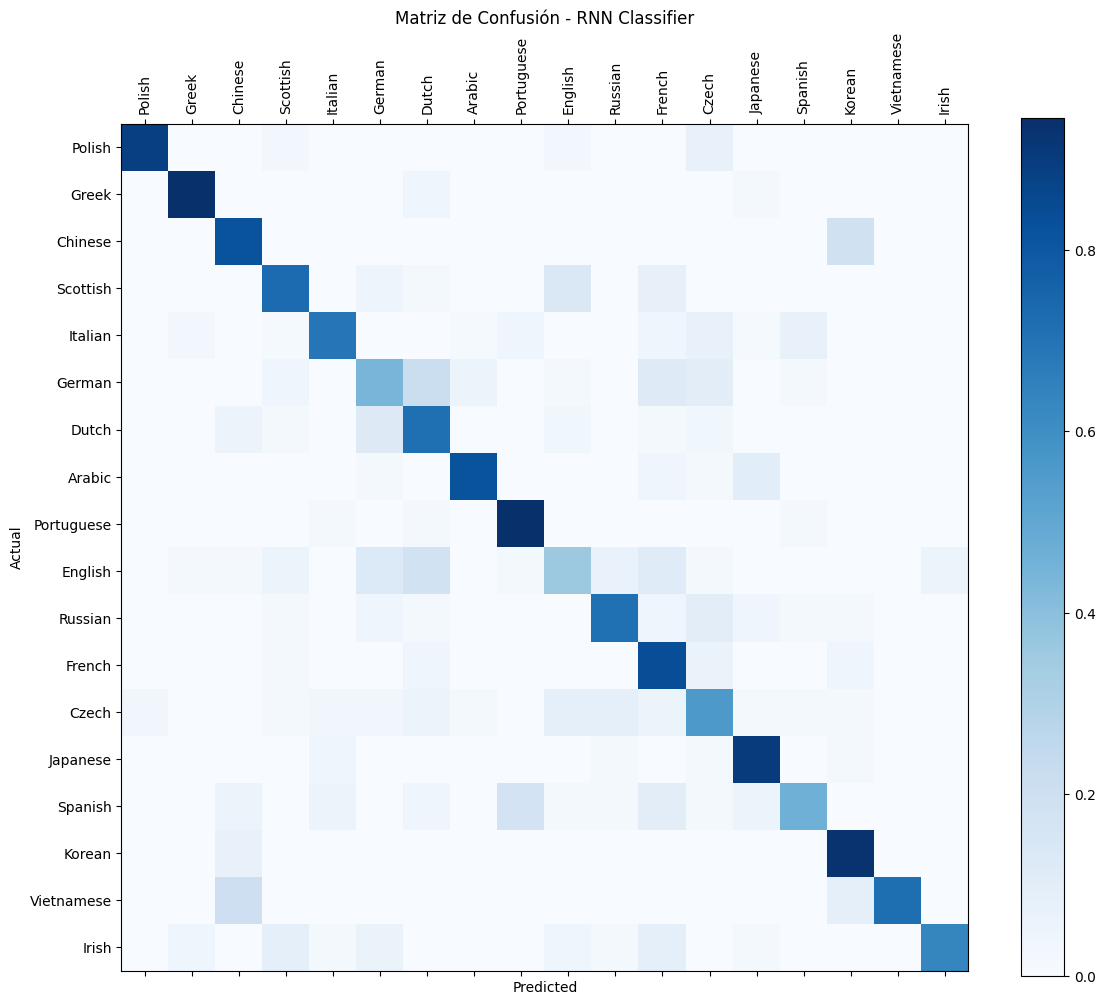

In [ ]:
# Evaluar el modelo (como en el original)
print("Evaluando el modelo...")

accuracy, confusion_matrix, categories = evaluate_model(model, data_module, n_samples=1000)

print(f"Precisión: {accuracy:.4f}")
print(f"Número de categorías: {len(categories)}")

# Visualizar matriz de confusión
plot_confusion_matrix(confusion_matrix, categories, 'Matriz de Confusión - RNN Classifier')

## Predicciones

Probamos el modelo con algunos nombres de ejemplo.

In [ ]:
# Probar predicciones con nombres de ejemplo
test_names = ['Dovesky', 'Jackson', 'Satoshi', 'Rodriguez', 'Mueller', 'Li', 'Nakamura', 'Smith']

print("Predicciones del modelo:")
print("=" * 50)

for name in test_names:
    predictions = predict_name_origin(model, name, categories, n_predictions=3)
    print()  # Línea en blanco entre predicciones

Predicciones del modelo:

> Dovesky
(-0.72) Czech
(-0.82) Russian
(-3.01) English


> Jackson
(-0.16) Scottish
(-2.07) English
(-4.76) Russian


> Satoshi
(-0.39) Japanese
(-1.69) Italian
(-2.68) Portuguese


> Rodriguez
(-0.48) Portuguese
(-1.54) Spanish
(-2.29) Dutch


> Mueller
(-0.76) Dutch
(-1.72) Czech
(-1.99) English


> Li
(-0.16) Vietnamese
(-2.36) Korean
(-3.03) Chinese


> Nakamura
(-0.01) Japanese
(-5.60) Portuguese
(-6.00) Arabic


> Smith
(-0.33) Scottish
(-2.19) German
(-2.92) Czech



## Conclusiones

La implementación con PyTorch Lightning ofrece las siguientes ventajas:

1. **Código más limpio y modular**: Separación clara de responsabilidades
2. **Mejor manejo de experimentos**: Logging automático y configuración fácil
3. **Escalabilidad**: Fácil adaptación a diferentes recursos de hardware
4. **Reproducibilidad**: Mejor control de semillas y configuraciones
5. **Funcionalidades avanzadas**: Early stopping, checkpointing, etc.
